In [1]:
# Code to wrap text in output cells on Colab to see the output clearly
# From https://github.com/jupyter/notebook/issues/6274
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

**Sentiment Analysis of IMDB Movie Reviews**

**Import necessary libraries**

In [2]:
#Load the libraries
!pip install numpy pandas seaborn textblob matplotlib nltk scikit-learn wordcloud bs4 spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score, f1_score




In [3]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
!pip install "tensorflow<2.11"

In [5]:
!pip install transformers flax

**Import the training dataset**

In [6]:
#importing the training data
!wget https://raw.githubusercontent.com/udbhav-44/BCS-Lluminating-Language/master/Week%201/movie.csv

import os
# Check current working directory
current_directory = os.getcwd()
print(f"Current Directory: {current_directory}")

# List files in the current directory
files_in_directory = os.listdir(current_directory)
print(f"Files in Directory: {files_in_directory}")


imdb_data=pd.read_csv('/content/movie.csv')
print(imdb_data.shape)
imdb_data.head(10)

--2024-06-05 18:17:31--  https://raw.githubusercontent.com/udbhav-44/BCS-Lluminating-Language/master/Week%201/movie.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52724248 (50M) [text/plain]
Saving to: ‘movie.csv.4’

movie.csv.4         100%[===================>]  50.28M   118MB/s    in 0.4s    

2024-06-05 18:17:32 (118 MB/s) - ‘movie.csv.4’ saved [52724248/52724248]

Current Directory: /content
Files in Directory: ['.config', 'movie.csv.4', 'movie.csv.2', 'movie.csv.1', 'movie.csv.3', 'movie.csv', 'sample_data']
(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


**Exploratery data analysis**

In [7]:
#Summary of the dataset
imdb_data.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


**Sentiment count**

In [8]:
#sentiment count
imdb_data['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

Data is balanced. There is NO Value other than 0 or 1 in the sentiment column. Clearly NO missing entries as all 40000 entries we can see filled with 0 or 1.

In [9]:
#Checking for Duplicates
duplicate = imdb_data[imdb_data.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate

Duplicate Rows :


,text,label
2164,"I find it rather useless to comment on this ""m...",0
3236,An absolutely atrocious adaptation of the wond...,0
3428,When I first saw this film it was not an impre...,0
3652,Before I watched this tv movie I did not know ...,1
3787,What a clunker!<br /><br />It MUST have been m...,0
...,...,...
39229,I Enjoyed Watching This Well Acted Movie Very ...,1
39246,You do realize that you've been watching the E...,0
39508,(Spoilers)<br /><br />Oh sure it's based on Mo...,0
39681,It's been a long time since I last saw a movie...,0


In [10]:
#Seems Like we have duplicate rows. Now time to delete them
imdb_data.drop_duplicates(inplace=True)
print(imdb_data)


                                                    text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[39723 rows x 2 columns]


In [11]:
#Checking for Duplicates again for assurance
duplicate = imdb_data[imdb_data.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate

Duplicate Rows :


,text,label


No duplicate entries now!!!!

In [12]:
#separating the positive and negative reviews, to analyse and furhter for train-test split
pos_rev = imdb_data[imdb_data['label']==1]
neg_rev = imdb_data[imdb_data['label']==0]

#The data is clearly not imbalanced
print("No. of Positive Reviews:", len(pos_rev))
print("No of Negative Reviews:", len(neg_rev))

No. of Positive Reviews: 19908
No of Negative Reviews: 19815


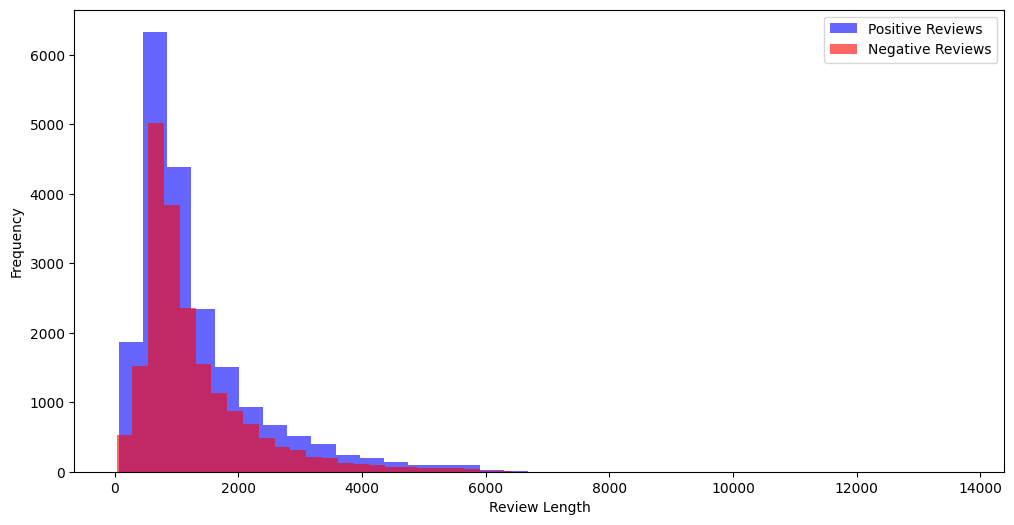

<Axes: xlabel='label', ylabel='count'>

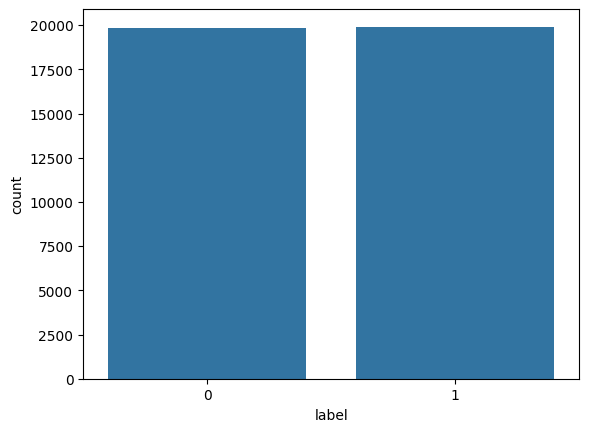

In [13]:
# Data Visualization
# How does the length of the reviews vs the sentiment look like
imdb_data['length'] = imdb_data['text'].apply(len)
imdb_data.head()

# Sentiment vs Length
plt.figure(figsize=(12,6))
imdb_data[imdb_data['label']==1]['length'].plot(bins=35, kind='hist', color='blue', label='Positive Reviews', alpha=0.6)
imdb_data[imdb_data['label']==0]['length'].plot(bins=35, kind='hist', color='red', label='Negative Reviews', alpha=0.6)
plt.legend()
plt.xlabel("Review Length")
plt.show()

sns.countplot(x='label', data=imdb_data)

# You can also plot the wordclouds (would make more sense after processing the data)

In [14]:
#Removing the html strips from the text as it may cause unnessarily increase in the no. of tokens with no added meaning. this is the only part of the data pre-processing which according to me is relevent.
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the noisy text by joining the two functions
def denoise_text(text):
    text = strip_html(text)
    return text
#Apply function on text column in the dataframe
imdb_data['text']=imdb_data['text'].apply(denoise_text)

<ipython-input-14-1e533ce6eb0b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


**The Dataset of reviews**

In [15]:
num_rows = 100 #Definign the no. of rows which you wanna take to train the model faster
reviews=imdb_data.text
reviews_list = reviews[:num_rows].tolist() #Converted the column to a list
print(reviews_list[:5])# Print the first 5 elements to verify
print(len(reviews_list))
review_data=np.array(reviews_list) #Converted into a NumPy array if needed
print(review_data)

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping t

In [16]:
#transformed sentiment data
sentiment_data=np.array(imdb_data['label'][:num_rows].tolist())
print(sentiment_data)
print(sentiment_data.shape)

[0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0
 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0]
(100,)


# Using Transformers by Custom Pipeline

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Predicting the output

In [18]:
# List to store prediction sentiments
prediction_sentiments = []

# Iterate over the review list
for review in reviews_list:
    # Tokenize the input review
    inputs = tokenizer(review, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # Predict the sentiment without computing gradients
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the predicted class id
    predicted_class_id = logits.argmax().item()

    # Append the prediction to the list (convert labels to 0 or 1)
    prediction_sentiments.append(predicted_class_id)


# Convert the list of predictions to a NumPy array
prediction_sentiments_array = np.array(prediction_sentiments)

# Print the NumPy array of predictions
print(prediction_sentiments_array)
print(sentiment_data)

[0 0 0 0 2 0 0 0 2 2 1 2 2 0 2 2 1 0 1 1 2 1 2 0 2 2 1 1 0 2 2 2 0 2 0 1 0
 0 0 1 0 0 2 1 2 2 1 0 2 0 2 0 2 0 2 0 1 2 2 2 2 1 0 2 2 2 1 1 0 0 2 0 1 1
 0 2 0 2 0 0 1 0 2 0 2 1 0 0 1 2 2 2 2 2 1 2 2 0 0 0]
[0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0
 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0]


In [19]:
# Create a mask to keep only the elements that are 0 or 2 in the prediction_sentiments_array
# Remove the neutral reviews (marked as 1) as they aren't helpful
mask = prediction_sentiments_array != 1

# Apply the mask to both arrays
filtered_prediction_sentiments_array = prediction_sentiments_array[mask]
filtered_sentiment_data = sentiment_data[mask]

# Convert remaining elements in filtered_prediction_sentiments_array to 1
filtered_prediction_sentiments_array[filtered_prediction_sentiments_array != 0] = 1

(filtered_prediction_sentiments_array, filtered_sentiment_data)


(array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]))

**Accuracy of the transformer model by Accuracy Score, F1 Score, ROC-AUC Score**

In [20]:
#Accuracy score
accuracy_score=accuracy_score(filtered_sentiment_data,filtered_prediction_sentiments_array)
print("accuracy_score :",accuracy_score)

#ROC_AUC score
roc_auc_score=roc_auc_score(filtered_sentiment_data,filtered_prediction_sentiments_array)
print("roc_auc_score :",roc_auc_score)

#F1 score
f1_score=f1_score(filtered_sentiment_data,filtered_prediction_sentiments_array)
print("f1_score :",f1_score)


accuracy_score : 0.8860759493670886
roc_auc_score : 0.8858974358974359
f1_score : 0.888888888888889


**Print the classification report**

In [21]:
#Classification report for bag of words
report=classification_report(filtered_sentiment_data,filtered_prediction_sentiments_array,target_names=['Positive','Negative'])
print(report)

#Positive means 1 label and negative means 0 label

              precision    recall  f1-score   support

    Positive       0.89      0.87      0.88        39
    Negative       0.88      0.90      0.89        40

    accuracy                           0.89        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.89      0.89      0.89        79



**Confusion matrix**

[[36  4]
 [ 5 34]]


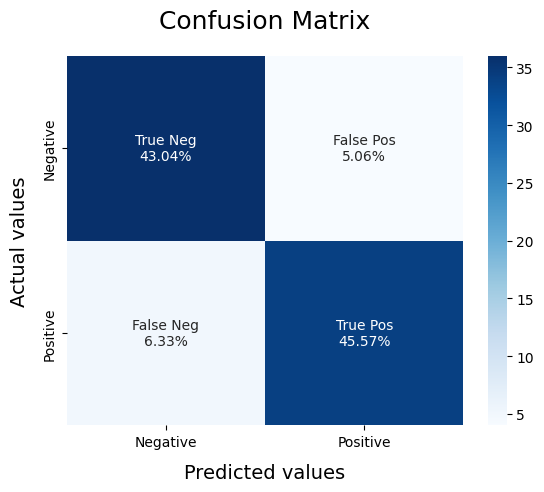

In [22]:
#confusion matrix for bag of words
cm=confusion_matrix(filtered_sentiment_data,filtered_prediction_sentiments_array,labels=[1,0])
print(cm)
categories = ['Negative', 'Positive']
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

# Arrange labels in the correct order
labels = [
    f'{group_names[3]}\n{group_percentages[3]}',  # True Neg
    f'{group_names[1]}\n{group_percentages[1]}',  # False Pos
    f'{group_names[2]}\n{group_percentages[2]}',  # False Neg
    f'{group_names[0]}\n{group_percentages[0]}',  # True Pos
]

# Reshape the labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, cmap='Blues', fmt='',
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
plt.show()

# **Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

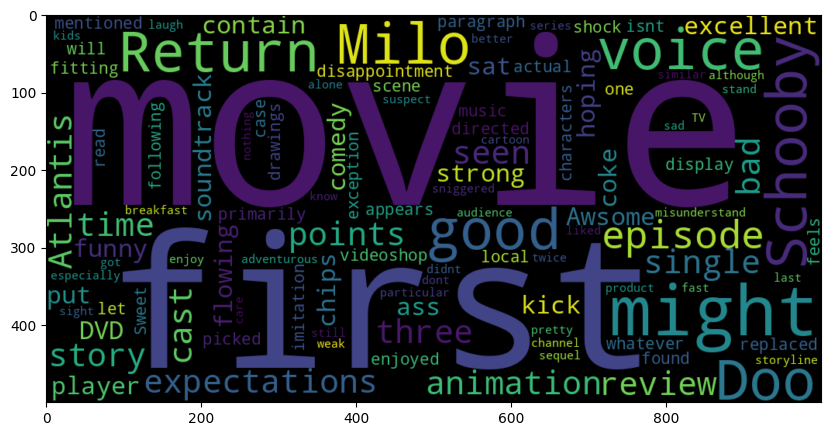

In [23]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=reviews_list[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

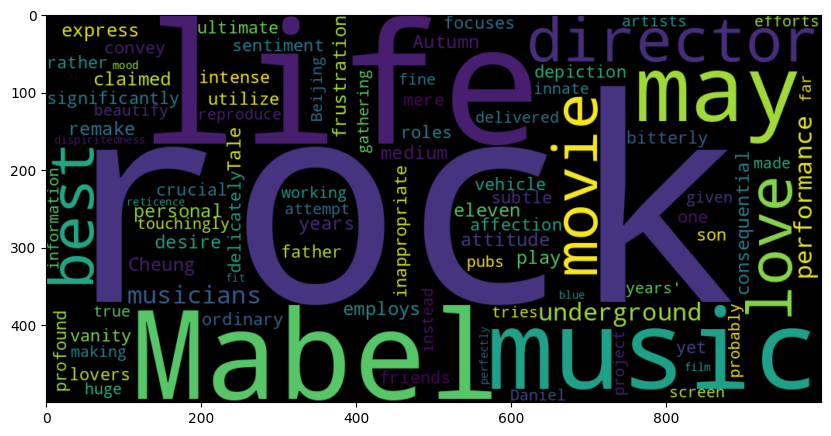

In [24]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=reviews_list[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

# References:
[Some Kaggle Notebooks](https://www.kaggle.com/),
[Medium Articles](https://www.medium.com),
[GfG Articles](https://www.geeksforgeeks.org/),
Google Search
